In [2]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sklearn.metrics import roc_curve, auc
%matplotlib inline
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', None)

# Load data

In [33]:
cancer = pd.read_csv('breast-cancer-wisconsin.csv',header=None)

In [34]:
cancer.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [35]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       699 non-null    int64 
 1   1       699 non-null    int64 
 2   2       699 non-null    int64 
 3   3       699 non-null    int64 
 4   4       699 non-null    int64 
 5   5       699 non-null    int64 
 6   6       699 non-null    object
 7   7       699 non-null    int64 
 8   8       699 non-null    int64 
 9   9       699 non-null    int64 
 10  10      699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


No missing values

# Data manipulation

## Transfer str to int

In [36]:
cancer[6].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [37]:
cancer[6].replace('?', 0, inplace = True)

In [38]:
cancer[6] =cancer[6].astype(int)

## Define cancer/not

In [39]:
cancer.head()
cancer[10] = np.where(cancer[10]==4, 1,0)

In [40]:
cancer.drop(columns = [0], inplace = True)

# EDA

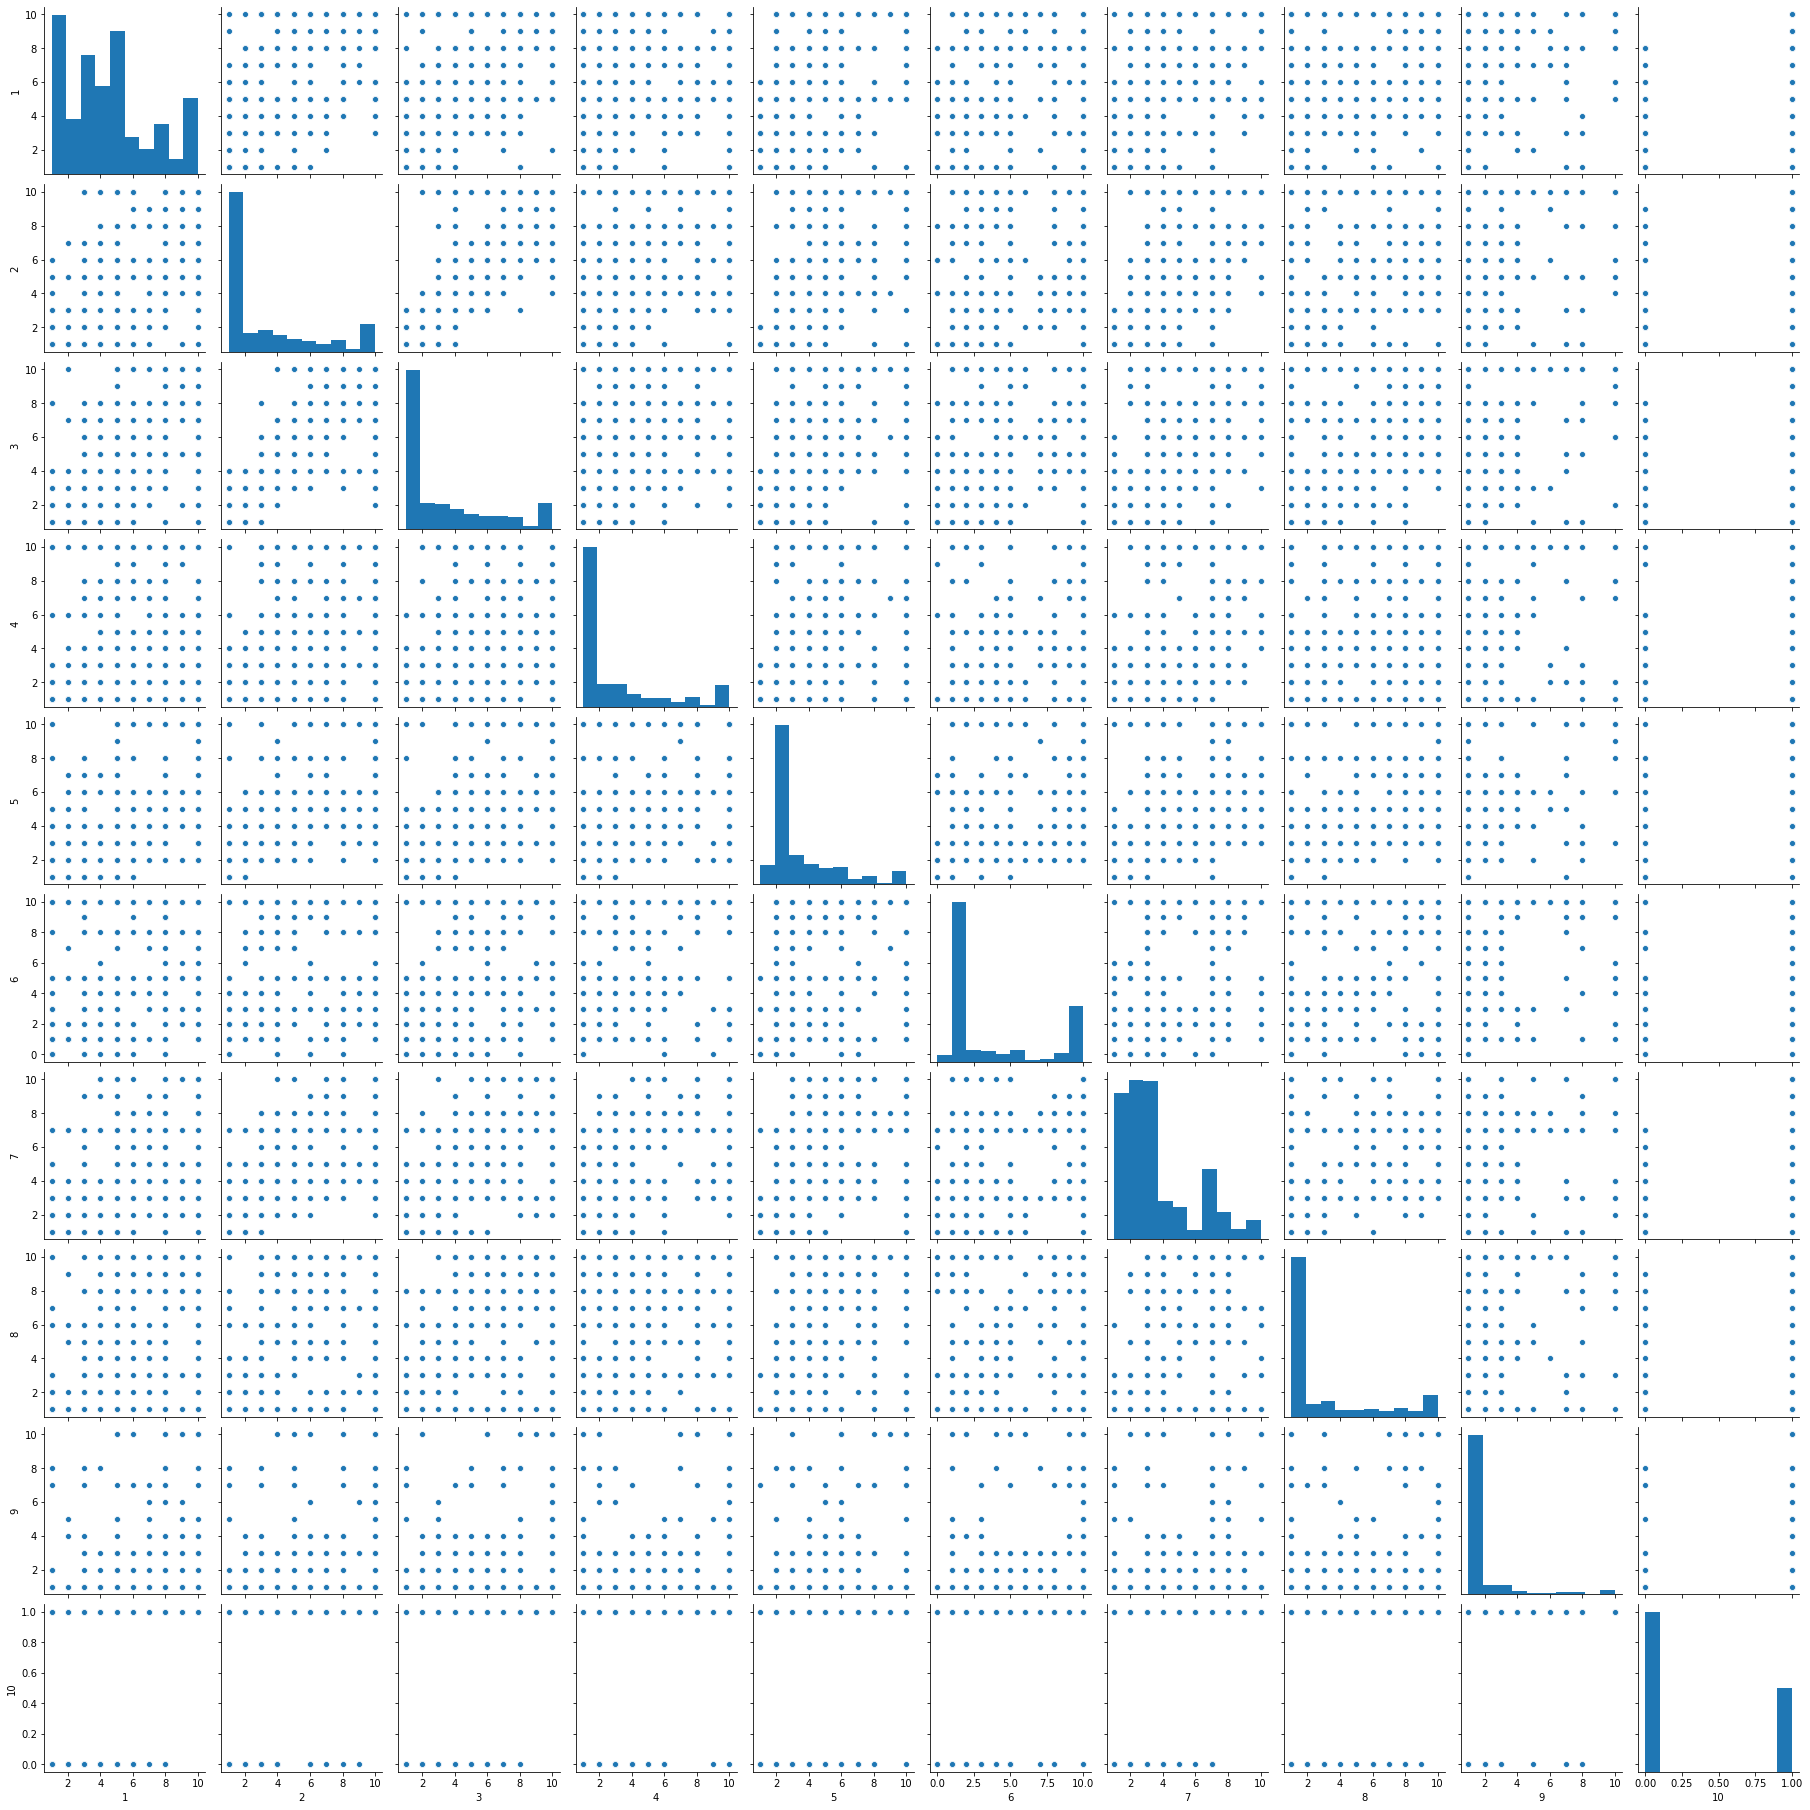

In [41]:
# Pairplot
sns.pairplot(cancer);

Data is imbalanced, but not seriously

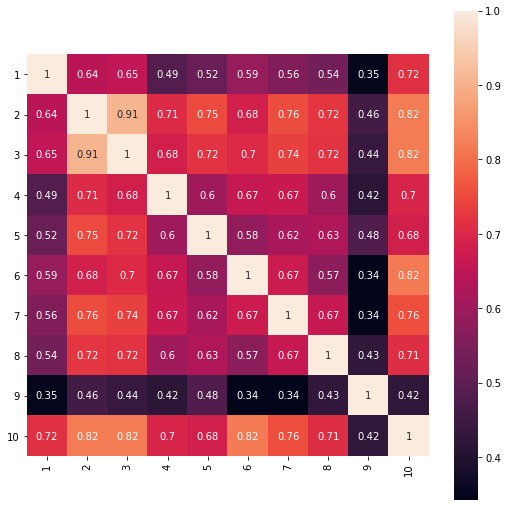

In [42]:
# correlation matrix
corr_mat = cancer.corr().abs()
fig, ax = plt.subplots(figsize= (9,9))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

1-8 are highly correlated to 10. 

2,3 are extremely correlated, might be the duplicated infos.

# Model

## Data preparation

In [43]:
feature = [1,2,3,4,5,6,7,8,9]
X =  cancer[feature]
y =  cancer[10]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

## Logist regression

1. The data is distributed from 1-10 uniformly, so do not need to scale
2. Logist regression is easy to implement and interpret.
3. For this problem, hope to predict all the 


In [52]:
import sklearn
from sklearn.metrics import roc_curve, auc, recall_score
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression().fit(X_train, y_train)

              precision    recall  f1-score   support

       not 1       0.98      0.97      0.97        98
           1       0.93      0.95      0.94        42

    accuracy                           0.96       140
   macro avg       0.95      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140



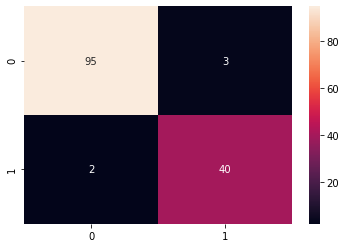

In [48]:
lr_predicted = model_lr.predict(X_test)
# Combined report with all above metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_predicted, target_names=['not 1', '1']))

cm = sklearn.metrics.confusion_matrix(y_test, lr_predicted)
sns.heatmap(cm, annot=True, fmt='d')

In [54]:
print(recall_score(y_test, lr_predicted))

0.9523809523809523


<ipython-input-49-a94558cc2b7d>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


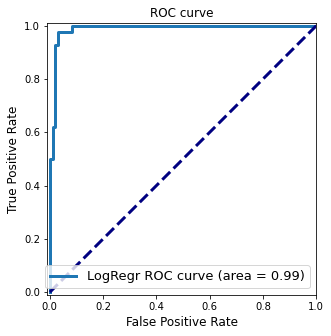

In [49]:
y_predict_lr_prop= model_lr.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predict_lr_prop[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize = (8,5))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve', fontsize=12)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

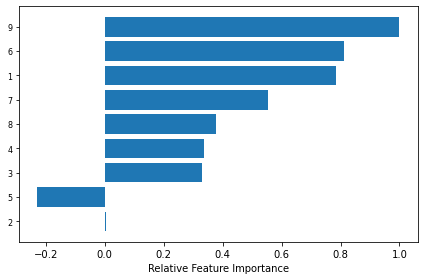

In [50]:
feature_importance = model_lr.coef_[0]
feature_importance = feature_importance / abs(feature_importance.max())
sorted_idx = np.argsort(abs(feature_importance))[-15:]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

9, 6, 1 are the important features, which are mitoses, Bare Nuclei, and clump thickness, respectively.
To effectively detect the cancer, can priorize these examination. 